<a href="https://colab.research.google.com/github/Fiap-RJ/FarmTechSolution_Fase6/blob/main/Fase6_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow keras

In [2]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import os

from sklearn.metrics import confusion_matrix
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Rescaling # Corrected import
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_dir = '/content/drive/MyDrive/IA-2025/FASE6/imagens'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')


In [5]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 20

In [6]:
print("Carregando dataset de treinamento...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

print("\nCarregando dataset de validação...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

# Nomes das classes inferidos automaticamente
class_names = train_dataset.class_names
print("\nClasses encontradas:", class_names)
num_classes = len(class_names)

Carregando dataset de treinamento...
Found 100 files belonging to 2 classes.

Carregando dataset de validação...
Found 9 files belonging to 2 classes.

Classes encontradas: ['furadeira', 'grampeador']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Definir a arquitetura da CNN -> camada de extração de features
hand_model = Sequential()
hand_model.add( Rescaling(1./255, input_shape=(150, 150, 3)) )
hand_model.add(     layers.Conv2D(16,     kernel_size=10, activation="relu") )
hand_model.add( layers.MaxPooling2D(3) )
hand_model.add(     layers.Conv2D(32,     kernel_size=8, activation="relu") )
hand_model.add( layers.MaxPooling2D(2) )
hand_model.add(     layers.Conv2D(32,     kernel_size=6, activation="relu") )
hand_model.add( layers.MaxPooling2D(2) )

#  Definir  a  arquitetura  da  CNN ->  camada  de  decisão (classificação)
hand_model.add( layers.Flatten() ) # entrada
hand_model.add(    layers.Dense(50,    activation="relu") ) # 1ª camada oculta
hand_model.add(    layers.Dense(20,    activation="relu") ) # 2ª camada oculta
hand_model.add(   layers.Dense(num_classes,   activation="softmax") ) # camada de decisão

# Compilar o modelo
hand_model.compile(optimizer="adam",
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

# Definir a estratégia de Early Stopping
es = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Treina o modelo
with tf.device("/device:GPU:0"):
  hand_model.fit(train_dataset,
                 epochs=EPOCHS,
                 validation_data=validation_dataset,
                 callbacks=[es])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 64s 14s/step - accuracy: 0.5568 - loss: 0.6796 - val_accuracy: 0.5556 - val_loss: 0.7065
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4705 - loss: 0.7056 - val_accuracy: 0.4444 - val_loss: 0.6766
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5563 - loss: 0.6546 - val_accuracy: 0.5556 - val_loss: 0.6438
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7445 - loss: 0.5905 - val_accuracy: 0.6667 - val_loss: 0.5595
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8620 - loss: 0.4410 - val_accuracy: 0.7778 - val_loss: 0.5643
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8803 - loss: 0.2864 - val_accuracy: 0.6667 - val_loss: 0.5018
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9020 - loss: 0.2721 - val_accuracy: 0.7778 - val_loss: 0.8456
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8895 - loss: 0.3203 - val_accuracy: 0.7778 - val_loss: 0.5338
Epoch 9/20
4/4

In [10]:
test_dir = os.path.join(base_dir, 'test')

print("Carregando dataset de teste...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Carregando dataset de teste...
Found 8 files belonging to 2 classes.


In [11]:
# Avaliação do modelo
loss, acc = hand_model.evaluate(test_dataset)
print(f"A  loss  do  modelo  é {loss:.2f}e  a  ACC  é {acc:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3750 - loss: 1.3251
A  loss  do  modelo  é 1.33e  a  ACC  é 0.38


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


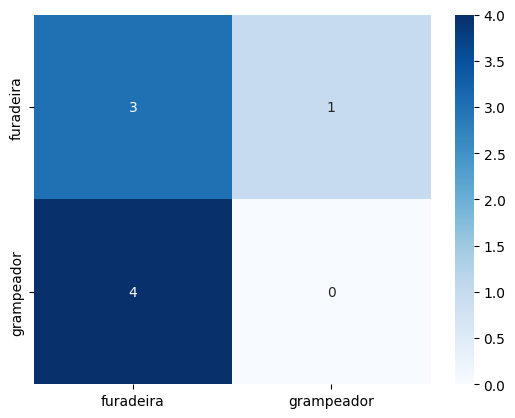

In [12]:
# Função para obter a matriz de confusão
def plot_confusion_matrix(y_test, y_pred):
  # Extrai os rótulos verdadeiros e previstos
  labels = np.concatenate([y for x, y in y_test], axis=0)
  labels_pred = np.argmax(y_pred, axis=1)

  # Calcula a matriz de confusão
  cf_matrix = confusion_matrix(labels, labels_pred)

  # Plota a matriz de confusão
  sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Obter previsões do modelo no conjunto de teste
preds = hand_model.predict(test_dataset)

# Matriz de confusão
plot_confusion_matrix(test_dataset, preds)

In [22]:
# Preprocessa os dados de treinamento e teste
# A função preprocess_input espera dados de imagem.
# Usaremos map para aplicar a função a cada elemento do dataset.

def preprocess_image(image, label):
    image = preprocess_input(image)
    return image, label

train_dsTL = train_dataset.map(preprocess_image)
test_dsTL = test_dataset.map(preprocess_image)

# Importar o modelo de base, que será a VGG16 ***sem*** a camada de decisão
# Definir o input_shape diretamente com as dimensões da imagem
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Usar os mesmos pesos da rede treinada (sem fazer fine tuning)
base_model.trainable = False

In [23]:
# Observa a estrutura do modelo importado
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
# Define as camadas
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation="relu")
dense_layer_2 = layers.Dense(20, activation="relu")
prediction_layer = layers.Dense(num_classes, activation="softmax")

# Estabelece o modelo completo
model = models.Sequential( [base_model, # A base CNN vem da VGG16
                            flatten_layer, # Achata as features que saem da VGG16 (base_model)
                            dense_layer_1, # 1ª camada oculta fully connected
                            dense_layer_2, # 2ª camada oculta fully connected
                            prediction_layer # Camada de saída, com 2 neurônios para classificação
                            ]
                            )

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │       409,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,125,400 (57.70 MB)

 Trainable params: 410,712 (1.57 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
# Compilar o modelo
model.compile(optimizer="adam",
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

# Definir a estratégia de Early Stopping
es = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True)

# Treina o modelo
with tf.device("/device:GPU:0"):
  model.fit(train_dsTL,
            epochs=50,
            validation_data=test_dsTL, # Usar o dataset de validação pré-processado
            callbacks=[es]
  )

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 10s/step - accuracy: 0.6363 - loss: 3.9982 - val_accuracy: 0.6250 - val_loss: 2.2097
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 9s/step - accuracy: 0.9230 - loss: 0.5255 - val_accuracy: 0.5000 - val_loss: 4.2117
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.6250 - val_loss: 5.5248
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.5000 - val_loss: 6.1640
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step - accuracy: 1.0000 - loss: 3.1995e-04 - val_accuracy: 0.5000 - val_loss: 6.6140
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step - accuracy: 1.0000 - loss: 1.3047e-04 - val_accuracy: 0.5000 - val_loss: 6.9078
